In [ ]:
from IPython.display import clear_output
! pip install bayesian-optimization
! pip install cvxopt
! pip install qpsolvers==3.4.0
# ! pip install accelerate==0.20.3 -U
! pip install git+https://github.com/simonzhang00/ripser-plusplus.git
! pip install git+https://github.com/IlyaTrofimov/RTD.git
clear_output()
!pip install -U lightautoml
!git clone https://github.com/mklabunde/resi.git
!pip install loguru
!pip install git+https://github.com/KhrulkovV/geometry-score.git
!pip install git+https://github.com/xgfs/imd.git
!pip install gudhi
!pip install --upgrade numpy catboost

clear_output()

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pickle
import sys
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = torch.device('cuda')

In [ ]:
sys.path.append('/content/resi/')
warnings.filterwarnings("ignore")
from repsim.measures import ALL_MEASURES
from repsim.measures import FUNCTIONAL_SIMILARITY_MEASURES
import rtd
from rtd.barcodes import h1sum, calc_embed_dist
from qpsolvers import solve_qp
warnings.filterwarnings("ignore")


2025-03-24 17:23:47.325 | INFO     | repsim.measures.rtd:__init__:56 - RTD will use cuda devices to compute barcodes. It is not possible to specify which GPU directly. Use the CUDA_VISIBLE_DEVICES environment variable to specify which GPU to use.
2025-03-24 17:23:47.326 | INFO     | repsim.measures.rtd:__init__:56 - RTD will use cuda devices to compute barcodes. It is not possible to specify which GPU directly. Use the CUDA_VISIBLE_DEVICES environment variable to specify which GPU to use.


In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции

In [ ]:
def save_res(dct, path):
  with open(path, 'wb') as handle:
      pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def load_res(path):
  try:
    with open(path, 'rb') as handle:
      results = pickle.load(handle)
  except:
    results = {}

  return results

In [ ]:
def opt_full(a, corr_matrix, n = 6):
  """
  полная оптимизация
  """
  P = 2 * corr_matrix
  c = np.diag(corr_matrix)
  q = a - c
  A = np.ones((1, corr_matrix.shape[0]))
  b = np.ones(1)
  lb = np.zeros(corr_matrix.shape[0])
  ub = np.ones(corr_matrix.shape[0])
  x_sol = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, initvals=np.ones(n)*1/n, solver='cvxopt', verbose=False)
  return x_sol

In [ ]:
def weight_embeds(tmp_emb, weights):
  final_embeds_train = tmp_emb[0][0].copy()
  final_embeds_test = tmp_emb[0][1].copy()

  # Применяем веса к копиям
  final_embeds_train.iloc[:, :256] = final_embeds_train.iloc[:, :256] * weights[0]
  final_embeds_test.iloc[:, :256] = final_embeds_test.iloc[:, :256] * weights[0]

  # Суммируем взвешенные эмбеддинги
  for i, (train, test) in enumerate(tmp_emb[1:], start=1):
      final_embeds_train.iloc[:, :256] += train.iloc[:, :256] * weights[i]
      final_embeds_test.iloc[:, :256] += test.iloc[:, :256] * weights[i]

  return final_embeds_train, final_embeds_test


def weight_embeds_w_val(tmp_emb, weights):
  final_embeds_train = tmp_emb[0][0].copy()
  final_embeds_test = tmp_emb[0][2].copy()

  # Применяем веса к копиям
  final_embeds_train.iloc[:, :256] = final_embeds_train.iloc[:, :256] * weights[0]
  final_embeds_test.iloc[:, :256] = final_embeds_test.iloc[:, :256] * weights[0]

  # Суммируем взвешенные эмбеддинги
  for i, (train, val, test) in enumerate(tmp_emb[1:], start=1):
      final_embeds_train.iloc[:, :256] += train.iloc[:, :256] * weights[i]
      final_embeds_test.iloc[:, :256] += test.iloc[:, :256] * weights[i]

  return final_embeds_train, final_embeds_test

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 200
TARGET_NAME = 'target'
roles = {
    'target': TARGET_NAME,
    'drop': ['client_id']
}
task = Task('multiclass', metric='crossentropy')


def calc_accuracy_of_combination(final_embeds_train, final_embeds_test):
  # Обучаем и оцениваем на первом наборе эмбеддингов
  automl = TabularAutoML(
      task=task,
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
  )

  # Обучаем модель и получаем out-of-fold предсказания
  out_of_fold_predictions = automl.fit_predict(final_embeds_train, roles=roles, verbose=0).data

  # Предсказания на тесте
  y_proba = automl.predict(final_embeds_test).data
  y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью



  # Метрики для многоклассовой классификации
  metrics = {
      "Accuracy": accuracy_score,
      "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
      "ROC-AUC": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
  }

  y_true = final_embeds_test[TARGET_NAME].values

  all_metrics = {
      metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
      for metric_name, metric_func in metrics.items()
  }

  return all_metrics

In [ ]:
def softmax(x, temperature=1.0):
    """Compute softmax values for each sets of scores in x."""
    x = x / temperature  # Scale the logits by the temperature
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=0)  # Normalize to get probabilities

# Подсчет качества отдельных моделей

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

100%|██████████| 102/102 [06:40<00:00,  3.93s/it]


In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
results = load_res(PATH)

In [ ]:
results

{}

In [ ]:
for i, (train, test) in enumerate(embeds):

  metrics = calc_accuracy_of_combination(train, test)
  results[i] = metrics
  save_res(results, PATH)
  clear_output()
  print(results[i])

{'Accuracy': 0.445, 'F1 Score': 0.4325103275943284, 'ROC-AUC': 0.7157440041770836}


# Конкатенация эмбеддингов

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

100%|██████████| 102/102 [03:39<00:00,  2.16s/it]


In [ ]:
def concat_embeds(embeds):

    # Проверка структуры входных данных
    for e in embeds:
        if len(e) != 2:
            raise ValueError("Каждый элемент embeds должен быть кортежем из 2 датафреймов.")

    # Конкатенация по столбцам для train, val, test
    concat_train = pd.concat([e[0].drop(columns = ['client_id', 'target']) for e in embeds], axis=1)
    concat_test = pd.concat([e[1].drop(columns = ['client_id', 'target']) for e in embeds], axis=1)

    concat_train.columns = [f'emb_{i}' for i in range(concat_train.shape[1])]
    concat_test.columns = [f'emb_{i}' for i in range(concat_test.shape[1])]

    concat_train['target'] = embeds[0][0]['target']
    concat_test['target'] = embeds[0][1]['target']

    return concat_train, concat_test

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance.pickle'
results = load_res(PATH)
n = 6

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'target'
roles = {
    'target': TARGET_NAME,
    'drop': ['client_id']
}
task = Task('multiclass', metric='crossentropy')


def calc_accuracy_of_combination(final_embeds_train, final_embeds_test):
  # Обучаем и оцениваем на первом наборе эмбеддингов
  automl = TabularAutoML(
      task=task,
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
  )

  # Обучаем модель и получаем out-of-fold предсказания
  out_of_fold_predictions = automl.fit_predict(final_embeds_train, roles=roles, verbose=0).data

  # Предсказания на тесте
  y_proba = automl.predict(final_embeds_test).data
  y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью



  # Метрики для многоклассовой классификации
  metrics = {
      "Accuracy": accuracy_score,
      "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
      "ROC-AUC": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
  }

  y_true = final_embeds_test[TARGET_NAME].values

  all_metrics = {
      metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
      for metric_name, metric_func in metrics.items()
  }

  return all_metrics

In [ ]:
%%time
for i in range(0, len(embeds), n):

  results[i] = {}

  tmp_emb = embeds[i:i+n].copy()

  concat_train, concat_test = concat_embeds(tmp_emb)

  metrs = calc_accuracy_of_combination(concat_train, concat_test)
  results[i]['uniform_emb_metrs'] = metrs
  save_res(results, PATH)

  clear_output()
  print(f'Эксперимент {i}')
  print(results[i])

  save_res(results, PATH)

Эксперимент 96
{'uniform_emb_metrs': {'Accuracy': 0.5376666666666666, 'F1 Score': 0.5317736480695252, 'ROC-AUC': 0.7962740343951392}}
CPU times: user 12h 51min 59s, sys: 1min 4s, total: 12h 53min 4s
Wall time: 3h 30min 20s


# Сумма эмбеддингов

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'target'
roles = {
    'target': TARGET_NAME,
    'drop': ['client_id']
}
task = Task('multiclass', metric='crossentropy')


def calc_accuracy_of_combination(final_embeds_train, final_embeds_test):
  # Обучаем и оцениваем на первом наборе эмбеддингов
  automl = TabularAutoML(
      task=task,
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
  )

  # Обучаем модель и получаем out-of-fold предсказания
  out_of_fold_predictions = automl.fit_predict(final_embeds_train, roles=roles, verbose=0).data

  # Предсказания на тесте
  y_proba = automl.predict(final_embeds_test).data
  y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью



  # Метрики для многоклассовой классификации
  metrics = {
      "Accuracy": accuracy_score,
      "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
      "ROC-AUC": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
  }

  y_true = final_embeds_test[TARGET_NAME].values

  all_metrics = {
      metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
      for metric_name, metric_func in metrics.items()
  }

  return all_metrics

1

In [ ]:
PATH = '/gdrive/MyDrive/PTLS/PTLS/data_ensemble_age_group/mean_perfomance.pickle'
results = load_res(PATH)
n = 6

In [ ]:
%%time
for i in range(0, len(embeds), n):

  results[i] = {}

  tmp_emb = embeds[i:i+n].copy()

  unif_weights = np.ones(len(tmp_emb))/len(tmp_emb)
  mean_train, mean_test = weight_embeds(tmp_emb, unif_weights)

  metrs = calc_accuracy_of_combination(mean_train, mean_test)
  results[i] = metrs
  save_res(results, PATH)

  clear_output()
  print(f'Эксперимент {i}')
  print(results[i])

  save_res(results, PATH)

# Сравнение суммы, конкатениции и максимума

In [ ]:
# # старое среднее, косячное
# metr = 'Accuracy'

# PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
# individual_accuracy = load_res(PATH)

# PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/my_metrics_weights.pickle'
# metrics = load_res(PATH)
# uniform = np.array([i['uniform_emb_metrs'][metr] for i in metrics.values()])

# ind_acc = np.array([i[metr] for i in individual_accuracy.values()])
# maximum_accuracy = []
# for i in range(0, 102, 6):
#   maximum_accuracy.append(max(ind_acc[i:i+6]))


# experiments = np.arange(1, len(maximum_accuracy) + 1)

# plt.figure(figsize=(10, 6))


# plt.plot(experiments, uniform, marker='o', label='uniform')
# plt.plot(experiments, maximum_accuracy, marker='^', label='ind_max')

# plt.title(f'Сравнение {metr} моделей', fontsize=16)
# plt.xlabel('Номер эксперимента', fontsize=14)
# plt.ylabel('Качество модели', fontsize=14)

# plt.legend(fontsize=12)

# plt.grid(True)

# # Показать график
# plt.show()

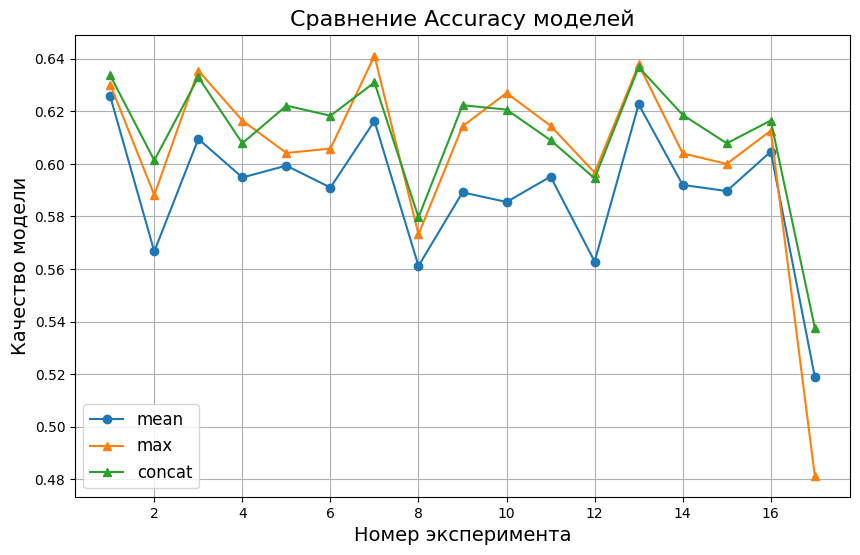

In [ ]:
metr = 'Accuracy'

PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
individual_accuracy = load_res(PATH)

PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/mean_perfomance.pickle'
mean = load_res(PATH)

PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance.pickle'
concat = load_res(PATH)


mean_metrs = np.array([i[metr] for i in mean.values()])
concat_metrs = np.array([i['uniform_emb_metrs'][metr] for i in concat.values()])



ind_acc = np.array([i[metr] for i in individual_accuracy.values()])
maximum_metrs = []
for i in range(0, 102, 6):
  maximum_metrs.append(max(ind_acc[i:i+6]))


experiments = np.arange(1, len(maximum_metrs) + 1)

plt.figure(figsize=(10, 6))


plt.plot(experiments, mean_metrs, marker='o', label='mean')
plt.plot(experiments, maximum_metrs, marker='^', label='max')
plt.plot(experiments, concat_metrs, marker='^', label='concat')

plt.title(f'Сравнение {metr} моделей', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество модели', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

Сравнение максимума и конката со средним

In [ ]:

metrics = [
    ('Max', maximum_metrs),
    ('Concat', concat_metrs)
]

results = []
for name, metric in metrics:
    diff = (metric - mean_metrs) / mean_metrs
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric > mean_metrs).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,Max,2.517965,2.961116,94.117647
1,Concat,3.679347,1.486141,100.000000


Сравнение конката с максимумом

In [ ]:
diff = (concat_metrs - maximum_metrs) / maximum_metrs
row = {
    'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
    'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
    'Better (%)': (metric > maximum_metrs).mean() * 100  # Процент случаев
}

# Создание и вывод таблицы
df = pd.DataFrame(row, index = [0])
df

,Mean (%),Std (%),Better (%)
0,1.207417,2.952977,58.823529


# Основные наблюдения

1. простое усреднение эмбеддингов не дает прирост к качеству относительно максимума в наборе.
2. Конкатенация дает прирост, но совсем небольшой

#Методы взвешивания из статьи(с валидационной выборкой)

# Считаем a и попарные метрики

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    val, test = train_test_split(test, test_size = 0.5, random_state=20)
    embeds.append((train, val, test))

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 200
TARGET_NAME = 'target'
roles = {
    'target': TARGET_NAME,
    'drop': ['client_id']
}

def calc_a(embeds_train, embeds_val, target_column, n_classes):
    # Определяем задачу как многоклассовую классификацию
    task = Task('multiclass', metric='crossentropy')

    automl = TabularAutoML(
        task=task,
        timeout=TIMEOUT,
        cpu_limit=N_THREADS,
        reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    )

    # Обучаем модель и получаем out-of-fold предсказания
    out_of_fold_predictions = automl.fit_predict(embeds_train, roles=roles, verbose=0).data

    # Предсказания на валидационной выборке
    y_proba = automl.predict(embeds_val).data
    y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью

    # Метрики для многоклассовой классификации
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
        "ROC-AUC": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
    }

    y_true = embeds_val[target_column].values

    all_metrics = {
        metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
        for metric_name, metric_func in metrics.items()
    }

    return all_metrics

In [ ]:
def find_nearest_neighbors(embeddings, k):
    """
    Находит k ближайших соседей для каждого объекта в наборе эмбеддингов.

    Args:
        embeddings (torch.Tensor): Матрица эмбеддингов (n_objects, embedding_dim).
        k (int): Количество ближайших соседей.

    Returns:
        torch.Tensor: Матрица размеров (n_objects, k), где указаны индексы ближайших соседей.
    """
    distances = torch.cdist(embeddings, embeddings)  # Вычисляем матрицу расстояний
    indices = torch.argsort(distances, dim=1)  # Сортируем по возрастанию расстояний
    return indices[:, 1:k+1]  # Пропускаем сам объект (индекс 0) и берем k соседей

def my_neighbour_metric_1(X, Y, k= 5):
    n_objects = X.shape[0]
    nbh_1 = find_nearest_neighbors(X, k)
    nbh_2 = find_nearest_neighbors(Y, k)

    matches = 0
    for obj in range(n_objects):
            # Сравниваем списки ближайших соседей
            neighbors_1 = set(nbh_1[obj].tolist())
            neighbors_2 = set(nbh_2[obj].tolist())
            matches += len(neighbors_1.intersection(neighbors_2))/k

    return matches / n_objects

def my_neighbour_metric_2(X, Y, k= 5):
    n_objects = X.shape[0]
    nbh_1 = find_nearest_neighbors(X, k)
    nbh_2 = find_nearest_neighbors(Y, k)

    matches = 0
    for obj in range(n_objects):
            # Сравниваем списки ближайших соседей
            neighbors_1 = set(nbh_1[obj].tolist())
            neighbors_2 = set(nbh_2[obj].tolist())
            matches += len(neighbors_1.intersection(neighbors_2)) / len(neighbors_1.union(neighbors_2))

    return matches / n_objects

In [ ]:
def extract_upper_triangle(matrix):
    """
    Извлекает верхний треугольник матрицы (без диагонали).
    """
    n = matrix.shape[0]
    indices = torch.triu_indices(n, n, offset=1)
    return matrix[indices[0], indices[1]]

def compute_correlation(distances1, distances2):
    """
    Вычисляет корреляцию между двумя векторами расстояний.
    """
    mean1, mean2 = distances1.mean(), distances2.mean()
    centered1, centered2 = distances1 - mean1, distances2 - mean2
    covariance = (centered1 * centered2).sum() / len(distances1)
    std1, std2 = distances1.std(), distances2.std()
    return covariance / (std1 * std2)

def my_correlation_metric(X, Y):
    distance_1 = extract_upper_triangle(torch.cdist(X, X))
    distance_2 = extract_upper_triangle(torch.cdist(Y, Y))
    metric = compute_correlation(distance_1, distance_2)
    return metric.item()

In [ ]:
def rtd1(cl1, cl2, pdist_device = 'cuda:0'):
    return h1sum(calc_embed_dist(cl1, cl2, pdist_device = pdist_device)), h1sum(calc_embed_dist(cl2, cl1, pdist_device = pdist_device))

def rtd_mine(cl1, cl2, pdist_device = 'cuda:0', trials = 10, batch = 500):

    assert cl1.shape[0] == cl2.shape[0]
    batch = min(batch, cl1.shape[0])

    rtd_avg = 0
    h1sum_1_avg = 0
    h1sum_2_avg = 0

    for i in range(trials):
        rnd_idx = list(range(cl1.shape[0]))
        np.random.shuffle(rnd_idx)
        rnd_idx = rnd_idx[:batch]
        h1sum_1, h1sum_2 = rtd1(cl1[rnd_idx], cl2[rnd_idx], pdist_device = pdist_device)
        h1sum_1_avg += h1sum_1
        h1sum_2_avg += h1sum_2
        rtd_avg += (h1sum_1 + h1sum_2)/2

    return rtd_avg / trials, h1sum_1_avg / trials, h1sum_2_avg / trials

In [ ]:
def calc_corr_matrix(embeds, metric, n = 6):
  if metric in ['RankSimilarity', 'CKA', 'RSA', 'OrthogonalAngularShapeMetricCentered', 'PermutationProcrustes']:
    cls = ALL_MEASURES[metric]
    corr_matrix = np.zeros((n, n))
    for i in range(n):
        emb_i = embeds[i][0].iloc[:, :256].values

        for j in range(i, n):
            emb_j = embeds[j][0].iloc[:, :256].values

            current_corr = cls(emb_i, emb_j, shape = 'nd')

            corr_matrix[i, j] = current_corr
            corr_matrix[j, i] = current_corr

    return corr_matrix

  elif metric == 'rtd':
    # тут будет несколько
    corr_matrix_h1 = np.zeros((n, n))
    corr_matrix_h2 = np.zeros((n, n))
    corr_matrix_rtd = np.zeros((n, n))

    for i in range(n):
        emb_i = torch.tensor(embeds[i][0].iloc[:, :256].values, device = device)

        for j in range(1, n):
            if i == j:
              corr_matrix_h1[i, j] = 0
              corr_matrix_h2[i, j] = 0
              corr_matrix_rtd[i, j] = 0
              continue


            emb_j = torch.tensor(embeds[j][0].iloc[:, :256].values, device = device)

            rtd, h1, h2 = rtd_mine(emb_i, emb_j, pdist_device = device)

            corr_matrix_h1[i, j] = h1
            corr_matrix_h2[i, j] = h2
            corr_matrix_rtd[i, j] = rtd

    return corr_matrix_h1, corr_matrix_h2, corr_matrix_rtd

  elif metric == 'my_correlation_metric':
    corr_matrix = np.zeros((n, n))
    for i in range(n):
        emb_i = torch.tensor(embeds[i][0].iloc[:, :256].values, device = device)

        for j in range(i, n):

            emb_j = torch.tensor(embeds[j][0].iloc[:, :256].values, device = device)

            current_corr = my_correlation_metric(emb_i, emb_j)

            corr_matrix[i, j] = current_corr
            corr_matrix[j, i] = current_corr

    return corr_matrix

Сначала посчитаем и сохраним без весов. Просто в каждом сеттинге качество (a) на oos + все метрики. Потом уже сообразим как это использовать в весах. Для каждой метрики будет по-разному.

In [ ]:
#rtd потом отдельно можно, очень долго считать

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/calc_a_and_b.pickle'
results = load_res(PATH)
n = 6

In [ ]:
# results.keys()

In [ ]:
%%time
all_metrs = ['RankSimilarity', 'CKA', 'RSA', 'OrthogonalAngularShapeMetricCentered', 'PermutationProcrustes', 'my_correlation_metric']#, 'rtd']

for i in range(0, len(embeds), n):

  if i in results.keys():
    continue

  print(f'Эксперимент {i}')
  results[i] = {}

  tmp_emb = embeds[i:i+n].copy()

  #a
  a = []
  for j in range(n):
    embeds_train = tmp_emb[j][0]
    embeds_val = tmp_emb[j][1]
    cur_a = calc_a(embeds_train, embeds_val, TARGET_NAME, 4)
    a.append(cur_a)
  results[i]['a'] = a


  # b
  for metr in all_metrs:
    if metr != 'rtd':
      corr_matrix = calc_corr_matrix(tmp_emb, metr)
      results[i][f'corr_matrix_{metr}'] = corr_matrix
      save_res(results, PATH)
    else:
      corr_matrix_h1, corr_matrix_h2, corr_matrix_rtd = calc_corr_matrix(tmp_emb, metr)
      results[i]['corr_matrix_h1'] = corr_matrix_h1
      results[i]['corr_matrix_h2'] = corr_matrix_h2
      results[i]['corr_matrix_rtd'] = corr_matrix_rtd
      save_res(results, PATH)

  clear_output()

CPU times: user 1d 1h 29min 7s, sys: 6h 19min 20s, total: 1d 7h 48min 27s
Wall time: 18h 21min 20s


In [ ]:
from google.colab import runtime
runtime.unassign()

# Метод взвешивания из статьи с разными метриками вместо B

## считаем метрики

In [ ]:
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    val, test = train_test_split(test, test_size = 0.5, random_state=20)
    embeds.append((train, val, test))

100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/calc_a_and_b.pickle'
a_corr = load_res(PATH)
n = 6

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/metrics_weights.pickle'
results = load_res(PATH)

In [ ]:
%%time
for i in range(0, len(embeds), n):
  if i in results.keys():
    continue

  print(f'Эксперимент {i}')
  results[i] = {}

  tmp_emb = embeds[i:i+n].copy()


  #считаем вектор a
  accuracy = [j['Accuracy'] for j in a_corr[i]['a']]
  a = [1 - j['Accuracy'] for j in a_corr[i]['a']]
  a, accuracy = np.array(a), np.array(accuracy)
  a_norm = a/a.max()

  # вместо B my_correlation_metric
  corr_matrix = a_corr[i]['corr_matrix_my_correlation_metric']
  opt_weights = opt_full(a_norm, corr_matrix)
  results[i]['my_correlation_metric_weights'] = opt_weights

  final_embeds_train, final_embeds_test = weight_embeds_w_val(tmp_emb, opt_weights)
  metrs = calc_accuracy_of_combination(final_embeds_train, final_embeds_test)
  results[i]['my_correlation_metric_emb_metrs'] = metrs
  save_res(results, PATH)
  clear_output()

  # вместо B CKA
  corr_matrix = a_corr[i]['corr_matrix_CKA']
  opt_weights = opt_full(a_norm, corr_matrix)
  results[i]['CKA_weights'] = opt_weights

  final_embeds_train, final_embeds_test = weight_embeds_w_val(tmp_emb, opt_weights)
  metrs = calc_accuracy_of_combination(final_embeds_train, final_embeds_test)
  results[i]['CKA_emb_metrs'] = metrs
  save_res(results, PATH)


  # вместо B RSA
  corr_matrix = a_corr[i]['corr_matrix_RSA']
  opt_weights = opt_full(a_norm, corr_matrix)
  results[i]['RSA_weights'] = opt_weights

  final_embeds_train, final_embeds_test = weight_embeds_w_val(tmp_emb, opt_weights)
  metrs = calc_accuracy_of_combination(final_embeds_train, final_embeds_test)
  results[i]['RSA_emb_metrs'] = metrs
  save_res(results, PATH)
  clear_output()


  #OrthogonalAngularShapeMetricCentered
  corr_matrix = a_corr[i]['corr_matrix_OrthogonalAngularShapeMetricCentered']
  corr_matrix = 1 - corr_matrix/corr_matrix.max()
  opt_weights = opt_full(a_norm, corr_matrix)
  results[i]['OrthogonalAngularShapeMetricCentered_weights'] = opt_weights

  final_embeds_train, final_embeds_test = weight_embeds_w_val(tmp_emb, opt_weights)
  metrs = calc_accuracy_of_combination(final_embeds_train, final_embeds_test)
  results[i]['OrthogonalAngularShapeMetricCentered_emb_metrs'] = metrs
  save_res(results, PATH)


  #вес пропорционален accuracy
  accuracy_weights = softmax(accuracy, 0.5)
  results[i]['accuracy_weights'] = accuracy_weights
  final_embeds_train, final_embeds_test = weight_embeds_w_val(tmp_emb, accuracy_weights)
  metrs = calc_accuracy_of_combination(final_embeds_train, final_embeds_test)
  results[i]['accuracy_emb_metrs'] = metrs
  save_res(results, PATH)

  clear_output()
  print(results[i])

{'my_correlation_metric_weights': array([0.19068683, 0.14326863, 0.30873831, 0.09792455, 0.17208245,
       0.08729924]), 'my_correlation_metric_emb_metrs': {'Accuracy': 0.511, 'F1 Score': 0.5030586443708085, 'ROC-AUC': 0.7747689064764953}, 'CKA_weights': array([0.15804658, 0.14948768, 0.28519802, 0.11913365, 0.17552669,
       0.11260737]), 'CKA_emb_metrs': {'Accuracy': 0.5123333333333333, 'F1 Score': 0.50526131687486, 'ROC-AUC': 0.7741680962776993}, 'RSA_weights': array([0.20137202, 0.11854747, 0.30015566, 0.11044326, 0.16532191,
       0.10415968]), 'RSA_emb_metrs': {'Accuracy': 0.515, 'F1 Score': 0.507190377618183, 'ROC-AUC': 0.7762649451954167}, 'OrthogonalAngularShapeMetricCentered_weights': array([0.17569456, 0.11450154, 0.251497  , 0.17628417, 0.12558706,
       0.15643567]), 'OrthogonalAngularShapeMetricCentered_emb_metrs': {'Accuracy': 0.5126666666666667, 'F1 Score': 0.5054879659658751, 'ROC-AUC': 0.7785032240690635}, 'accuracy_weights': array([0.1705788 , 0.13082546, 0.18952

+ добавим еще качество на тесте без валидации. неужели оно так сильно отличается?

In [ ]:
%%time
for i in range(0, len(embeds), n):

  print(f'Эксперимент {i}')

  tmp_emb = embeds[i:i+n].copy()

  weights = np.ones(n)/n
  final_embeds_train, final_embeds_test = weight_embeds_w_val(tmp_emb, weights)
  metrs = calc_accuracy_of_combination(final_embeds_train, final_embeds_test)
  results[i]['uniform_metrs'] = metrs
  save_res(results, PATH)
  clear_output()

CPU times: user 2h 41min 26s, sys: 2min, total: 2h 43min 27s
Wall time: 44min 56s


In [ ]:
from google.colab import runtime
runtime.unassign()

## сравнение по качеству

загрузка максимума, среднего и конкатенации

In [ ]:
ind_acc

array([], dtype=float64)

In [ ]:
metr = 'Accuracy'

PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
individual_accuracy = load_res(PATH)

#здесь timeout 300 и lama лучше обучилась, нечестное соревнование
# PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/mean_perfomance.pickle'
# mean = load_res(PATH)
# mean_metrs = np.array([i[metr] for i in mean.values()])

#аналогично для concat, но тут не пересчитываю
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance.pickle'
concat = load_res(PATH)
concat_metrs = np.array([i['uniform_emb_metrs'][metr] for i in concat.values()])



ind_acc = np.array([i[metr] for i in individual_accuracy.values()])
maximum_metrs = []
for i in range(0, 102, 6):
  maximum_metrs.append(max(ind_acc[i:i+6]))

In [ ]:
maximum_metrs = np.array(maximum_metrs)

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/metrics_weights.pickle'
results = load_res(PATH)

mean_metrs = np.array([i['uniform_metrs'][metr] for i in results.values()])
my_correlation_metric = np.array([i['my_correlation_metric_emb_metrs'][metr] for i in results.values()])
CKA_metric = np.array([i['CKA_emb_metrs'][metr] for i in results.values()])
RSA_metric = np.array([i['RSA_emb_metrs'][metr] for i in results.values()])
OrthogonalAngularShapeMetricCentered_metric = np.array([i['OrthogonalAngularShapeMetricCentered_emb_metrs'][metr] for i in results.values()])
# accuracy_w = np.array([i['accuracy_emb_metrs'][metr] for i in results.values()])

<ipython-input-3-f10bc467a461>:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results = pickle.load(handle)


Сравнение с средним

In [ ]:
# Сравнение всех метрик с mean
metrics = [
    ('CKA', CKA_metric),
    ('RSA', RSA_metric),
    ('my_correlation', my_correlation_metric),
    ('OrthogonalAngularShapeMetricCentered', OrthogonalAngularShapeMetricCentered_metric)
]

results = []
for name, metric in metrics:
    diff = (metric - mean_metrs) / mean_metrs
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric > mean_metrs).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,CKA,1.390887,1.454615,70.588235
1,RSA,1.361126,1.634579,76.470588
2,my_correlation,1.314764,1.616302,76.470588
3,OrthogonalAngularShapeMetricCentered,1.515249,1.315415,82.352941


Сравнение с максимумом

In [ ]:
# Сравнение всех метрик с mean
metrics = [
    ('CKA', CKA_metric),
    ('RSA', RSA_metric),
    ('my_correlation', my_correlation_metric),
    ('OrthogonalAngularShapeMetricCentered', OrthogonalAngularShapeMetricCentered_metric)
]

results = []
for name, metric in metrics:
    diff = (metric - maximum_metrs) / maximum_metrs
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric > maximum_metrs).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,CKA,-2.735573,3.078526,5.882353
1,RSA,-2.760771,3.267425,17.647059
2,my_correlation,-2.810954,3.076638,11.764706
3,OrthogonalAngularShapeMetricCentered,-2.622682,2.817199,5.882353


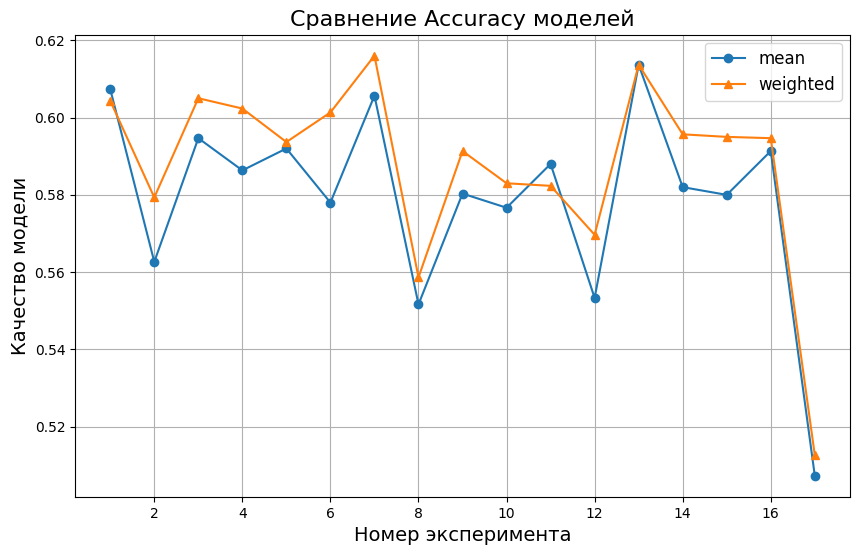

In [ ]:
experiments = np.arange(1, len(maximum_metrs) + 1)

plt.figure(figsize=(10, 6))


plt.plot(experiments, mean_metrs, marker='o', label='mean')
# plt.plot(experiments, maximum_metrs, marker='^', label='max')
plt.plot(experiments, OrthogonalAngularShapeMetricCentered_metric, marker='^', label='weighted')

plt.title(f'Сравнение {metr} моделей', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество модели', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

Сравним с весами по качеству

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/metrics_weights.pickle'
results = load_res(PATH)
acc_w = []
for i in range(0, 96, 6):
  acc_w.append(results[i]['accuracy_emb_metrs']['Accuracy'])
acc_w = np.array(acc_w)

<ipython-input-3-f10bc467a461>:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results = pickle.load(handle)


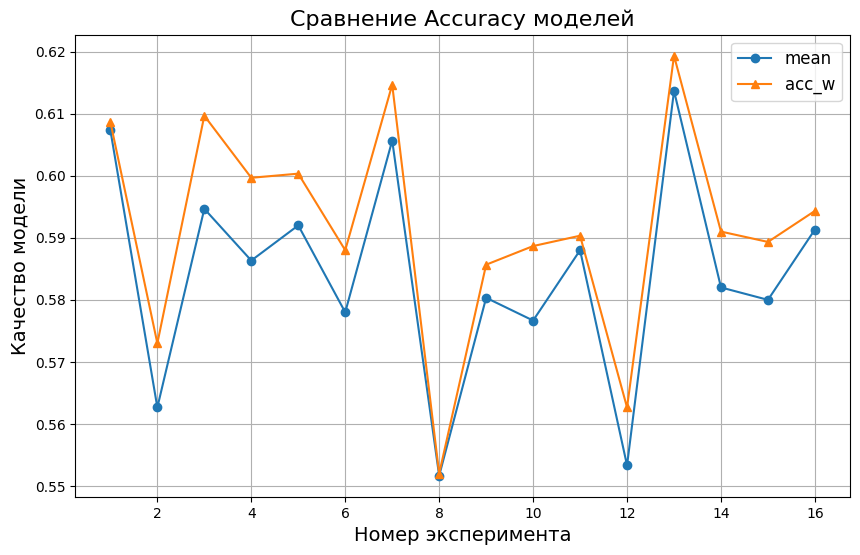

In [ ]:
experiments = np.arange(1, len(maximum_metrs) + 1)

plt.figure(figsize=(10, 6))


plt.plot(experiments[:-1], mean_metrs[:-1], marker='o', label='mean')
# plt.plot(experiments, maximum_metrs, marker='^', label='max')
plt.plot(experiments[:-1], acc_w, marker='^', label='acc_w')

plt.title(f'Сравнение {metr} моделей', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество модели', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
diff = (acc_w - mean_metrs[:-1]) / mean_metrs[:-1]
diff.mean(), diff.std(), (acc_w > mean_metrs[:-1]).mean()

(np.float64(0.013254036708952529),
 np.float64(0.007203466527308464),
 np.float64(1.0))

## Итоги:
1) Среднее хуже конката и максимума \
2) Взвешанное среднее лучше просто среднего, но хуже конката \

Всегда нужно ставить одинаковый TIMEOUT у LAMA и делать стратифицированный по таргету train_test_split!!!

# Эксперименты с качеством эмбеддингов вместо качества на валидации

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

100%|██████████| 102/102 [02:17<00:00,  1.35s/it]


In [ ]:
TIMEOUT = 300

##метрики из репо

Код метрик отсюда https://github.com/google-research/google-research/blob/master/graph_embedding/metrics/metrics.py

In [ ]:
"""A library for computing unsupervised embedding quality metrics."""
from typing import Mapping, Optional

import numpy as np


def report_all_metrics(tensor):
  """Computes all metric values given a tensor and its SVD.

  Args:
    tensor (dense matrix): Input embeddings.

  Returns:
    Mapping[str, float]: All metric values.
  """
  # Pre-compute SVD for metric computations.
  u, s, _ = np.linalg.svd(tensor, compute_uv=True, full_matrices=False)
  fns = [
      rankme,
      coherence,
      pseudo_condition_number,
      alpha_req,
      stable_rank,
      ne_sum,
      self_clustering,
  ]
  return dict((fn.__name__, fn(tensor, u=u, s=s)) for fn in fns)


def pseudo_condition_number(
    tensor,
    s = None,
    epsilon = 1e-12,
    **_
):
  """Implementation of the pseudo-condition number metric.

  Args:
    tensor (dense matrix): Input embeddings.
    s (optional, dense vector): Singular values of `tensor`.
    epsilon (float): Numerical epsilon.

  Returns:
    float: Pseudo-condition number metric value.
  """
  if s is None:
    s = np.linalg.svd(tensor, compute_uv=False)
  return s[-1] / (s[0] + epsilon)


def coherence(tensor, u = None, **_):
  """Implementation of the coherence metric.

  Args:
    tensor (dense matrix): Input embeddings.
    u (optional, dense matrix): Left singular vectors of `tensor`.

  Returns:
    float: Coherence metric value.
  """
  if u is None:
    u, _, _ = np.linalg.svd(tensor, compute_uv=True, full_matrices=False)
  maxu = np.linalg.norm(u, axis=1).max() ** 2
  return maxu * u.shape[0] / u.shape[1]


def stable_rank(
    tensor,
    s = None,
    epsilon = 1e-12,
    **_
):
  """Implementation of the stable rank metric.

  Args:
    tensor (dense matrix): Input embeddings.
    s (optional, dense vector): Singular values of `tensor`.
    epsilon (float): Numerical epsilon.

  Returns:
    float: Stable rank metric value.
  """
  if s is None:
    s = np.linalg.svd(tensor, compute_uv=False)
  trace = np.square(tensor).sum()
  denominator = s[0] * s[0] + epsilon
  return trace / denominator


def self_clustering(tensor, epsilon = 1e-12, **_):
  """Implementation of the SelfCluster metric.

  Args:
    tensor (dense matrix): Input embeddings.
    epsilon (float): Numerical epsilon.

  Returns:
    float: SelfCluster metric value.
  """
  tensor = tensor + epsilon
  tensor /= np.linalg.norm(tensor, axis=1)[:, np.newaxis]
  n, d = tensor.shape
  expected = n + n * (n - 1) / d
  actual = np.sum(np.square(tensor @ tensor.T))
  return (actual - expected) / (n * n - expected)


def rankme(
    tensor,
    s = None,
    epsilon = 1e-12,
    **_
):
  """Implementation of the RankMe metric.

  This metric is defined in "RankMe: Assessing the Downstream Performance of
  Pretrained Self-Supervised Representations by Their Rank". Garrido et al.
  arXiv:2210.02885.

  Args:
    tensor (dense matrix): Input embeddings.
    s (optional, dense vector): Singular values of `tensor`.
    epsilon (float): Numerical epsilon.

  Returns:
    float: RankMe metric value.
  """
  if s is None:
    s = np.linalg.svd(tensor, compute_uv=False)
  p_ks = s / np.sum(s + epsilon) + epsilon
  return np.exp(-np.sum(p_ks * np.log(p_ks)))


def ne_sum(tensor, epsilon = 1e-12, **_):
  """Implementation of the NESum metric.

  This metric is defined in "Exploring the Gap between Collapsed & Whitened
  Features in Self-Supervised Learning". He & Ozay, ICML 2022. See Definition
  4.1 from the paper for more details.

  Args:
    tensor (dense matrix): Input embeddings.
    epsilon (float): Numerical epsilon.

  Returns:
    float: NESum metric value.
  """
  cov_t = np.cov(tensor.T)
  ei_t = np.linalg.eigvalsh(cov_t) + epsilon
  return (ei_t / ei_t[-1]).sum()


def alpha_req(
    tensor,
    s = None,
    epsilon = 1e-12,
    **_
):
  """Implementation of the Alpha-ReQ metric.

  This metric is defined in "α-ReQ: Assessing representation quality in
  self-supervised learning by measuring eigenspectrum decay". Agrawal et al.,
  NeurIPS 2022.

  Args:
    tensor (dense matrix): Input embeddings.
    s (optional, dense vector): Singular values of `tensor`.
    epsilon (float): Numerical epsilon.

  Returns:
    float: Alpha-ReQ metric value.
  """
  if s is None:
    s = np.linalg.svd(tensor, compute_uv=False)
  n = s.shape[0]
  s = s + epsilon
  features = np.vstack([np.linspace(1, 0, n), np.ones(n)]).T
  a, _, _, _ = np.linalg.lstsq(features, np.log(s), rcond=None)
  return a[0]

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/calc_a_and_b.pickle'
a_corr = load_res(PATH)

In [ ]:
def calc_qualities(embeds):
    '''
    возвращает словарь с ключом - названием метрики, значением - массивом соответствующих значений
    '''
    metrics = []
    for embed in embeds:
      cur_embed = embed[0].values[:, :256]
      results = report_all_metrics(cur_embed)
      metrics.append(results)

    return {key: np.array([d[key] for d in metrics])
        for key in metrics[0].keys()}

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/my_metrics_weights.pickle'
results = load_res(PATH)
n = 6

In [ ]:
results

{}

In [ ]:
%%time
for i in range(0, len(embeds), n):

  results[i] = {}

  tmp_emb = embeds[i:i+n].copy()  # [N, D]

  corr_matrix = a_corr[i]['corr_matrix_CKA'] #[6,6]

  qualities = calc_qualities(tmp_emb) # качество эмбеддингов

  #берем только 3-4 метрики для быстроты
  for metric in ['pseudo_condition_number', 'rankme', 'coherence', 'self_clustering']:

    a = qualities[metric]

    if metric == 'pseudo_condition_number': # чем ментше тем лучше
      log_pcn = np.log10(a)
      log_min = log_pcn.min()
      log_max = log_pcn.max()
      a = (log_pcn - log_min) / (log_max - log_min)
    else:
      #нормализуем
      a = a/a.max()
      #метрики показывают качество, нам нужна ошибка
      a = [1 - i for i in a]

    opt_weights = opt_full(a, corr_matrix)
    results[i][f'opt_weights_{metric}'] = opt_weights

    final_embeds_train, final_embeds_test = weight_embeds(tmp_emb, opt_weights)
    metrs = calc_accuracy_of_combination(final_embeds_train, final_embeds_test)
    results[i][f'opt_emb_metrs_{metric}'] = metrs
    save_res(results, PATH)

    clear_output()

  print(f'Эксперимент {i}')
  print(results[i])

Эксперимент 96
{'opt_weights_pseudo_condition_number': array([2.89729282e-08, 9.50356334e-02, 1.85042983e-01, 1.76849165e-01,
       2.54559031e-02, 5.17616287e-01]), 'opt_emb_metrs_pseudo_condition_number': {'Accuracy': 0.5128333333333334, 'F1 Score': 0.505326127110321, 'ROC-AUC': 0.7835897316880251}, 'opt_weights_rankme': array([6.10154919e-08, 1.72072563e-01, 2.38753271e-01, 1.62685242e-01,
       4.23792489e-01, 2.69637465e-03]), 'opt_emb_metrs_rankme': {'Accuracy': 0.5083333333333333, 'F1 Score': 0.4984208642990574, 'ROC-AUC': 0.7692175576536155}, 'opt_weights_coherence': array([1.42471057e-01, 8.57645444e-02, 3.34293238e-01, 3.37939180e-09,
       7.75097345e-07, 4.37470382e-01]), 'opt_emb_metrs_coherence': {'Accuracy': 0.52, 'F1 Score': 0.5130886277753125, 'ROC-AUC': 0.7829389874396627}, 'opt_weights_self_clustering': array([1.91532283e-01, 3.93656915e-02, 2.92016867e-01, 2.23250146e-01,
       1.06747740e-06, 2.53833945e-01]), 'opt_emb_metrs_self_clustering': {'Accuracy': 0.522

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/my_metrics_weights.pickle'
results = load_res(PATH)

<ipython-input-4-f10bc467a461>:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results = pickle.load(handle)


In [ ]:
results[0].keys()

dict_keys(['opt_weights_pseudo_condition_number', 'opt_emb_metrs_pseudo_condition_number', 'opt_weights_rankme', 'opt_emb_metrs_rankme', 'opt_weights_coherence', 'opt_emb_metrs_coherence', 'opt_weights_self_clustering', 'opt_emb_metrs_self_clustering'])

надем победителя по метрикам

In [ ]:
metr = 'Accuracy'
# uniform = np.array([i['uniform_emb_metrs'][metr] for i in results.values()])
rankme = np.array([i['opt_emb_metrs_rankme'][metr] for i in results.values()])
coherence  = np.array([i['opt_emb_metrs_coherence'][metr] for i in results.values()])
clustering  = np.array([i['opt_emb_metrs_self_clustering'][metr] for i in results.values()])
pseudo_condition_number  = np.array([i['opt_emb_metrs_pseudo_condition_number'][metr] for i in results.values()])

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/mean_perfomance.pickle'
mean = load_res(PATH)
mean_metrs = np.array([i[metr] for i in mean.values()])

Сравниваем все метрики со средним

In [ ]:
# Сравнение всех метрик с mean
metrics = [
    ('rankme', rankme),
    ('coherence', coherence),
    ('clustering', clustering),
    ('pseudo_condition_number', pseudo_condition_number)
]

results = []
for name, metric in metrics:
    diff = (metric - mean_metrs) / mean_metrs
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric > mean_metrs).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,rankme,-3.444348,4.468292,23.529412
1,coherence,-3.170850,6.492412,47.058824
2,clustering,-0.223205,2.986977,52.941176
3,pseudo_condition_number,-0.945163,4.510633,41.176471


## Вывод:
1) при подстановке метрик качества результат не улучшается